## Heat Effects in a Semibatch Reactor 

You can download Fogler's book from here: https://drive.google.com/file/d/1LtiobP6y6RGY7dWe5ssa2RJ2JR99sbYV/view?usp=drive_link

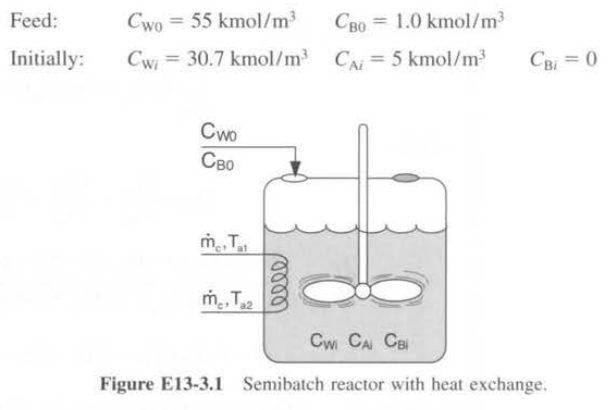

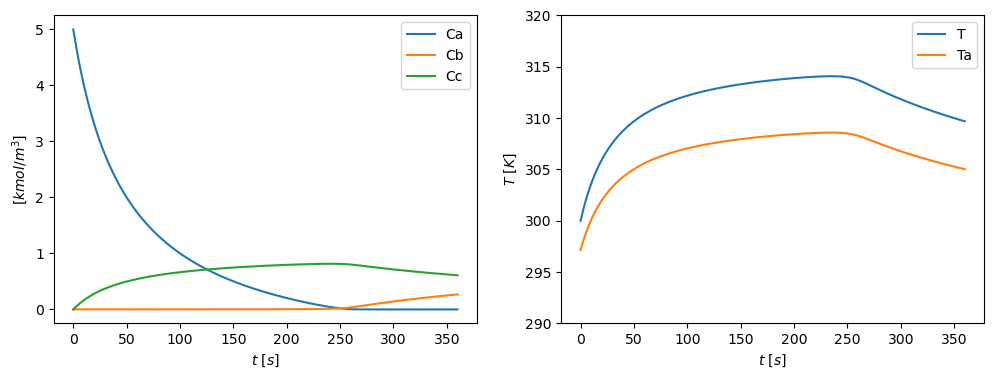

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# components
components = 4

# feed - continuously
v0 = 0.004 # volumetric rate in m3/s
Cb0 = 1 # aqueous sodium hydroxide is to be fed at this concentration at 300K
Fb0 = Cb0*v0
Cw0 = 55
thetaW = Cw0/Cb0

# initially
V_in = 0.2 # initial volume of water and ethyl acetate
Ca_in = 5
Cb_in = 0
Cw_in = 30.7
Nw_in = V_in*Cw_in

UA = 3000 # the reaction is exothermic and it is necessary to add a heat exchanger to keep T < 315K
Ta = 290
cp = 7.524e04
T0 = 300
dh = -7.9076e07
Cpa = 170700
Cpc = 18
Ta1 = 285 # coolant temperature
mc = 100 # the coolant enters at a rate of 100 kg/s

def ode(t, params):
    
    C = params[:-2]
    T = params[-2]
    Nw = params[-1]
    
    # reaction rate
    k = 0.39175*np.exp(5472.7*((1/273)-(1/T)))
    Kc = 10**(3885.44/T)
    ra = -k*((C[0]*C[1])-((C[2]*C[3])/Kc))

    # stoichiometry
    V = V_in+v0*t
    Na = V*C[0]
    Nb = V*C[1]
    Nc = V*C[2]
    Nd = V*C[3]
    rb = ra
    rc = -ra
    
    # differential equation
    dCdt = np.zeros(components)
    dCdt[0] = ra-(v0*C[0])/V
    dCdt[1] = rb+(v0*(Cb0-C[1])/V)
    dCdt[2] = rc-(C[2]*v0)/V
    dCdt[3] = rc-(C[2]*v0)/V
    
    NCp = cp*(Nb+Nc+Nd+Nw)+Cpa*Na
    Qr = mc*Cpc*(Ta1-T)*(1-np.exp(-UA/mc/Cpc))
    # only B and water continuosly flow to the reactor so ΣFi0Cpi
    dTdt = (Qr-(Fb0)*cp*(1+thetaW)*(T-T0)+ra*V*dh)/NCp
    
    dNwdt = v0*Cw0
    
    return np.hstack([dCdt, dTdt, dNwdt])

t = np.linspace(0, 360, 1000)

x0 = [Ca_in, Cb_in, 0, 0, T0, Nw_in]

sol = solve_ivp(ode, [t[0], t[-1]], x0, t_eval=t)

V = V_in+v0*t

Ca = sol.y[0]
Cb = sol.y[1]
Cc = sol.y[2]
Cd = sol.y[3]

T = sol.y[4]
Ta2 = T-(T-Ta1)*np.exp(-UA/mc/Cpc)

Nw = sol.y[5]

fig, ax = plt.subplots(ncols=2, figsize=(12,4))

ax[0].plot(sol.t, Ca, label = 'Ca')
ax[0].plot(sol.t, Cb, label = 'Cb')
ax[0].plot(sol.t, Cc, label = 'Cc')
ax[0].set_xlabel('$t~[s]$')
ax[0].set_ylabel('$[kmol/m^3]$')
ax[0].legend()

ax[1].plot(sol.t, T, label = 'T')
ax[1].plot(sol.t, Ta2, label = 'Ta')
ax[1].set_ylim(290, 320)
ax[1].set_xlabel('$t~[s]$')
ax[1].set_ylabel('$T~[K]$')
ax[1].legend()